# Key Considerations from Preprocessing and EDA:
* No missing values: Since there are no missing values, we don’t need to handle imputation.
* Categorical Variables: Some features such as C1, C2, and XC are categorical and should be encoded before feeding into the models. need to ensure that these are appropriately one-hot encoded.
* Standardization: The continuous variables such as X1, X2, etc., should be standardized. This helps models like linear models or neural networks.
* Imbalanced Treatment: We observed class imbalance between treated and control groups. Handling this imbalance will be crucial for fair treatment effect estimation.
* Interaction Effects: There may be interaction effects between treatment and school covariates (e.g., X1, X2) that could influence CATE, especially in models like X-learner and R-learner

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
import numpy as np
from sklearn.utils import resample
import seaborn as sns
import matplotlib.pyplot as plt
import timeout_decorator


In [2]:
# Load  data
dataset = pd.read_csv('../data/dataset.csv')

In [3]:
# Rename columns for clarity
dataset = dataset.rename(columns={
    'Y': 'StudentAchievementScore',
    'Z': 'GrowthMindsetIntervention',
    'S3': 'FutureSuccessExpectations',
    'C1': 'StudentRaceEthnicity',
    'C2': 'StudentGender',
    'C3': 'FirstGenCollegeStatus',
    'XC': 'SchoolUrbanicity',
    'X1': 'PreInterventionFixedMindset',
    'X2': 'SchoolAchievementLevel',
    'X3': 'SchoolMinorityComposition',
    'X4': 'PovertyConcentration',
    'X5': 'TotalStudentPopulation'
})

In [4]:
# Define covariates, treatment, and outcome
covariate_cols = ['FutureSuccessExpectations', 'StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 
                  'SchoolUrbanicity', 'PreInterventionFixedMindset', 'SchoolAchievementLevel', 
                  'SchoolMinorityComposition', 'PovertyConcentration', 'TotalStudentPopulation']
treatment_col = 'GrowthMindsetIntervention'
outcome_col = 'StudentAchievementScore'

In [5]:
# Split data into training and testing sets (with stratification on treatment variable)
train_data, test_data = train_test_split(dataset, test_size=0.3, random_state=42, stratify=dataset[treatment_col])

In [6]:
# Preprocessing: Standardize continuous variables and one-hot encode categorical variables
continuous_cols = ['PreInterventionFixedMindset', 'SchoolAchievementLevel', 'SchoolMinorityComposition', 
                   'PovertyConcentration', 'TotalStudentPopulation']

categorical_cols = ['StudentRaceEthnicity', 'StudentGender', 'FirstGenCollegeStatus', 'SchoolUrbanicity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), continuous_cols),
        ('cat', OneHotEncoder(), categorical_cols)
    ]
)

In [7]:
# 6. Fit and transform the training data (covariates only)
X_train_processed = preprocessor.fit_transform(train_data[covariate_cols])
y_train = train_data[outcome_col].values
treatment_train = train_data[treatment_col].values

In [8]:
param_grids = {
    'RandomForest': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [100, 200, 500],  # Number of trees
            'max_depth': [None, 10, 20],  # Maximum depth of the tree
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
            'max_features': ['sqrt', 'log2', None]  # Number of features to consider when looking for the best split
        }
    },
    'GradientBoosting': {
        'model': GradientBoostingRegressor(),
        'params': {
            'n_estimators': [100, 200, 500],  # Number of boosting stages
            'learning_rate': [0.01, 0.05, 0.1],  # Step size shrinkage used in each boosting step
            'max_depth': [3, 5, 10],  # Maximum depth of individual estimators
            'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
            'subsample': [0.8, 1.0]  # Fraction of samples used for fitting the individual estimators
        }
    },
    'NeuralNetwork': {
        'model': MLPRegressor(max_iter=1000),  # Neural network regressor
        'params': {
            'hidden_layer_sizes': [(50,), (100,), (100, 100)],  # Size of the hidden layers
            'activation': ['relu', 'tanh'],  # Activation functions
            'solver': ['adam', 'lbfgs'],  # Solver for weight optimization
            'learning_rate_init': [0.001, 0.01]  # Initial learning rate
        }
    },
    'Ridge': {
        'model': Ridge(),
        'params': {
            'alpha': [0.01, 0.1, 1.0, 10.0, 100.0]  # Regularization strength
        }
    },
    'SVR': {
        'model': SVR(),
        'params': {
            'kernel': ['linear', 'rbf'],  # Type of kernel
            'C': [0.1, 1.0, 10.0],  # Regularization parameter
            'epsilon': [0.1, 0.2, 0.5]  # Epsilon in the epsilon-SVR model
        }
    },
    'AdaBoost': {
        'model': AdaBoostRegressor(),
        'params': {
            'n_estimators': [50, 100, 200],  # Number of boosting stages
            'learning_rate': [0.01, 0.1, 0.5]  # Shrinks the contribution of each estimator
        }
    },
    'ExtraTrees': {
        'model': ExtraTreesRegressor(),
        'params': {
            'n_estimators': [100, 200, 500],  # Number of trees in the forest
            'max_depth': [None, 10, 20],  # Maximum depth of the tree
            'min_samples_split': [2, 5, 10]  # Minimum number of samples required to split a node
        }
    }
}


In [9]:
def bootstrap_emse(X_train, y_train, treatment_train, model, n_bootstraps=10, meta_learner='S-Learner'):
    mse_list = []
    
    for _ in range(n_bootstraps):
        # Bootstrap resampling
        X_boot, y_boot, t_boot = resample(X_train, y_train, treatment_train)
        
        if meta_learner == 'S-Learner':
            X_boot = np.column_stack([X_boot, t_boot])
            model.fit(X_boot, y_boot)
            cate_pred = model.predict(X_boot)
        
        elif meta_learner == 'T-Learner':
            # Separate models for treatment and control groups
            X_treat, y_treat = X_boot[t_boot == 1], y_boot[t_boot == 1]
            X_control, y_control = X_boot[t_boot == 0], y_boot[t_boot == 0]
            
            model_treat = model.__class__(**model.get_params())  # New instance of the model
            model_control = model.__class__(**model.get_params())  # New instance of the model
            
            model_treat.fit(X_treat, y_treat)
            model_control.fit(X_control, y_control)
            
            # Predict for all data (X_treat + X_control) so that shapes match when calculating CATE
            treat_pred = model_treat.predict(X_boot)
            control_pred = model_control.predict(X_boot)
            cate_pred = treat_pred - control_pred

        elif meta_learner == 'X-Learner':
            # X-Learner first fits the T-Learner, then fits pseudo outcomes
            model_treat = model.__class__(**model.get_params())
            model_control = model.__class__(**model.get_params())
            X_treat, y_treat = X_boot[t_boot == 1], y_boot[t_boot == 1]
            X_control, y_control = X_boot[t_boot == 0], y_boot[t_boot == 0]
            
            model_treat.fit(X_treat, y_treat)
            model_control.fit(X_control, y_control)
            
            # Compute pseudo-outcomes
            tau_treat = y_treat - model_control.predict(X_treat)
            tau_control = model_treat.predict(X_control) - y_control
            
            # Refit the models using the pseudo-outcomes
            model_treat.fit(X_control, tau_control)
            model_control.fit(X_treat, tau_treat)
            cate_pred = np.concatenate([
                model_treat.predict(X_control),
                model_control.predict(X_treat)
            ])

        elif meta_learner == 'R-Learner':
            # Step 1: Residualize the outcome and treatment
            model_y = model.__class__(**model.get_params())  # New instance for outcome regression
            model_t = model.__class__(**model.get_params())  # New instance for treatment regression
            model_y.fit(X_boot, y_boot)
            model_t.fit(X_boot, t_boot)
            
            y_residual = y_boot - model_y.predict(X_boot)
            t_residual = t_boot - model_t.predict(X_boot)
            
            # Step 2: Regress the outcome residuals on treatment residuals
            model.fit(t_residual.reshape(-1, 1), y_residual)
            cate_pred = model.predict(t_residual.reshape(-1, 1))
        
        # Compute the MSE for this bootstrap sample
        mse_boot = mean_squared_error(y_boot, cate_pred)
        mse_list.append(mse_boot)
    
    # Compute the Expected MSE (EMSE)
    emse = np.mean(mse_list)
    return emse


In [10]:
def grid_search_cv(X_train, y_train, treatment_train, model, params, meta_learner):
    """
    Perform GridSearchCV for hyperparameter tuning and return the best model, EMSE, MAE, and R².
    """
    y_train = y_train.ravel()  # Ensure y_train is 1D
    
    # For S-Learner, combine covariates and treatment into a single dataset
    if meta_learner == 'S-Learner':
        X = np.column_stack([X_train, treatment_train])
    else:
        X = X_train
    
    # Run GridSearchCV to find the best parameters
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X, y_train)
    
    # Get the best model from the search
    best_model = grid_search.best_estimator_
    best_params = grid_search.best_params_

    if meta_learner == 'R-Learner':
        # Residualize the outcome and treatment for R-Learner
        model_y = model.__class__(**model.get_params())  # New instance for outcome regression
        model_t = model.__class__(**model.get_params())  # New instance for treatment regression
        model_y.fit(X_train, y_train)
        model_t.fit(X_train, treatment_train)
        
        y_residual = y_train - model_y.predict(X_train)
        t_residual = treatment_train - model_t.predict(X_train)

        # Final CATE regression on residualized treatment
        best_model.fit(t_residual.reshape(-1, 1), y_residual)
        y_pred = best_model.predict(t_residual.reshape(-1, 1))
    
    else:
        # For S-Learner and others
        if meta_learner == 'S-Learner':
            X_best = np.column_stack([X_train, treatment_train])
        else:
            X_best = X_train
        
        y_pred = best_model.predict(X_best)
    
    # Calculate evaluation metrics
    best_mae = mean_absolute_error(y_train, y_pred)
    best_r2 = r2_score(y_train, y_pred)
    
    # Compute EMSE using bootstrapping
    emse = bootstrap_emse(X_train, y_train, treatment_train, best_model, n_bootstraps=100, meta_learner=meta_learner)
    
    return best_model, emse, best_mae, best_r2, best_params


In [11]:
# Example of running grid search for each model and meta-learner
results = []
meta_learners = ['S-Learner', 'T-Learner', 'X-Learner', 'R-Learner']

for model_name, config in param_grids.items():
    for learner in meta_learners:
        print(f"Running GridSearchCV for {model_name} using {learner}...")
        # Run the grid search using the preprocessed data
        best_model, best_emse, best_mae, best_r2,best_params = grid_search_cv(X_train_processed, y_train, 
                                                                treatment_train, 
                                                                config['model'], config['params'], learner)
        
        # Store results
        result = {
            'model': model_name,
            'learner': learner,
            'best_emse': best_emse,
            'best_mae': best_mae,
            'best_r2': best_r2,
            'best_params': best_params
        }
        results.append(result)
        
        print(f"{learner} {model_name} Results: Best EMSE={best_emse:.4f}, Best MAE={best_mae:.4f}, Best R²={best_r2:.4f}")
        
# Convert results to a DataFrame for easy viewing
results_df = pd.DataFrame(results)


Running GridSearchCV for RandomForest using S-Learner...
S-Learner RandomForest Results: Best EMSE=0.2914, Best MAE=0.4540, Best R²=0.2445
Running GridSearchCV for RandomForest using T-Learner...
T-Learner RandomForest Results: Best EMSE=0.6192, Best MAE=0.4676, Best R²=0.1956
Running GridSearchCV for RandomForest using X-Learner...
X-Learner RandomForest Results: Best EMSE=0.5921, Best MAE=0.4678, Best R²=0.1951
Running GridSearchCV for RandomForest using R-Learner...
R-Learner RandomForest Results: Best EMSE=0.3636, Best MAE=0.5090, Best R²=0.0549
Running GridSearchCV for GradientBoosting using S-Learner...
S-Learner GradientBoosting Results: Best EMSE=0.3184, Best MAE=0.4638, Best R²=0.2125
Running GridSearchCV for GradientBoosting using T-Learner...
T-Learner GradientBoosting Results: Best EMSE=0.5998, Best MAE=0.4760, Best R²=0.1680
Running GridSearchCV for GradientBoosting using X-Learner...
X-Learner GradientBoosting Results: Best EMSE=0.5946, Best MAE=0.4755, Best R²=0.1685
Run

In [27]:
# Save the results as a CSV file
results_df.to_csv('grid_search_results.csv', index=False)
# Load the stored results from the CSV file
results_df = pd.read_csv('grid_search_results.csv')

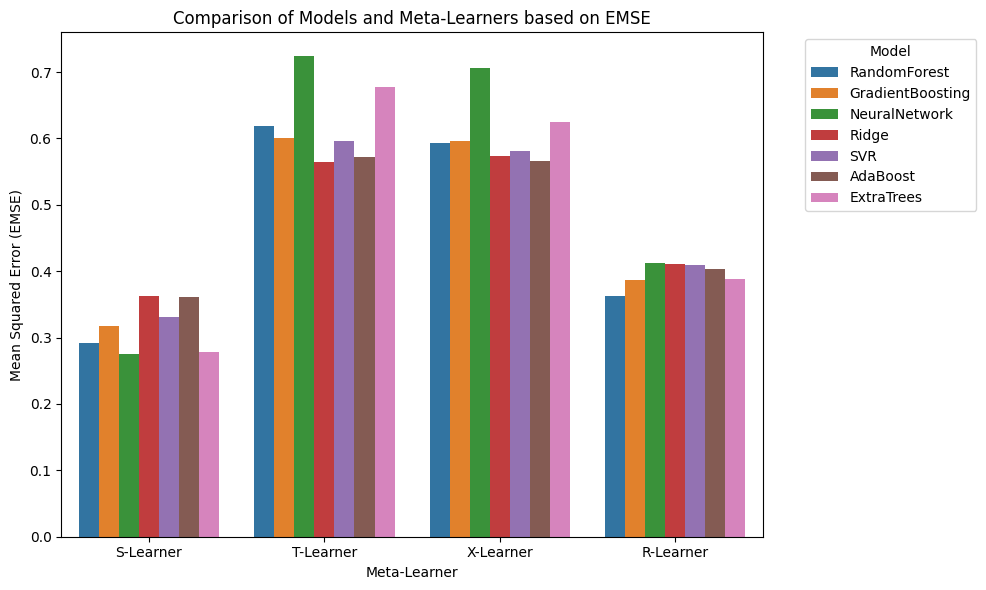

In [28]:
# 1. Bar Plot of MSE
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(x='learner', y='best_emse', hue='model', data=results_df)
plt.title('Comparison of Models and Meta-Learners based on EMSE')
plt.xlabel('Meta-Learner')
plt.ylabel('Mean Squared Error (EMSE)')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


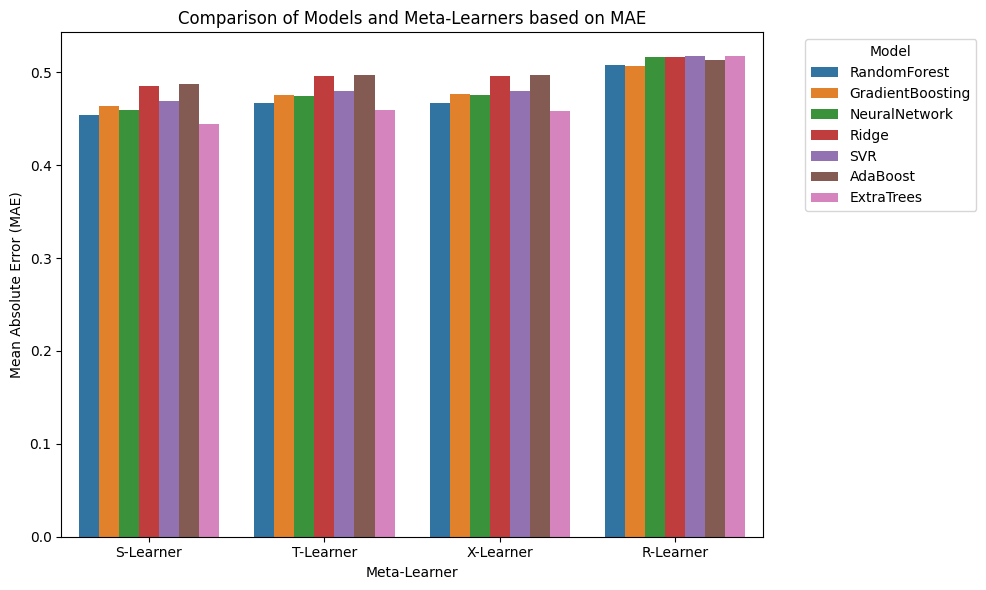

In [29]:
# 2. Bar Plot of MAE
plt.figure(figsize=(10, 6))
sns.barplot(x='learner', y='best_mae', hue='model', data=results_df)
plt.title('Comparison of Models and Meta-Learners based on MAE')
plt.xlabel('Meta-Learner')
plt.ylabel('Mean Absolute Error (MAE)')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


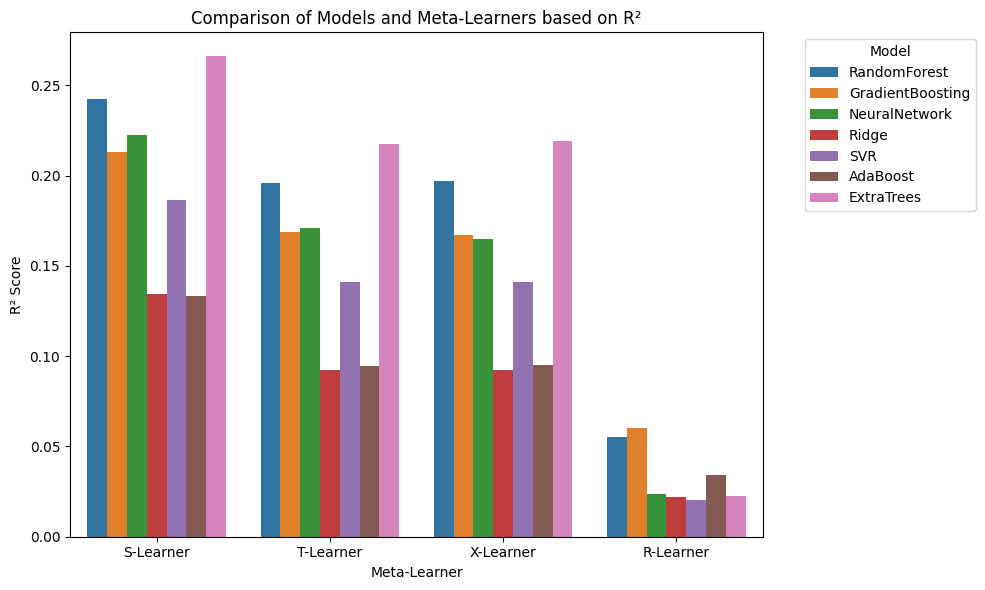

In [30]:
# 3. Bar Plot of R²
plt.figure(figsize=(10, 6))
sns.barplot(x='learner', y='best_r2', hue='model', data=results_df)
plt.title('Comparison of Models and Meta-Learners based on R²')
plt.xlabel('Meta-Learner')
plt.ylabel('R² Score')
plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


# Results 
## Key Metrics:
* Expected Mean Squared Error (EMSE): Lower values indicate better model performance, as the error between predicted and true treatment effects is minimized.
* Mean Absolute Error (MAE): Like EMSE, a lower value indicates better predictive accuracy.
* R² (R-squared): This measures the proportion of the variance in the outcome that is predictable from the covariates. Higher values (closer to 1) are better, indicating a better fit.
## Conclusions about Performance:
Based on the results of the visualizations and the data for each learner, here is the best model selection with its corresponding parameters for each meta-learner:

* S-Learner:

    * Model: Neural Network
    * Best Parameters: {'activation': 'tanh', 'hidden_layer_sizes': (50,), 'learning_rate_init': 0.001, 'solver': 'adam'}
    * Reason: It has the lowest EMSE (0.275) and a relatively strong R² (0.222).

* T-Learner:
    * Model: Extra Trees
    * Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
    * Reason: It provides a good balance between EMSE (0.677) and MAE (0.459), with the highest R² (0.217) among the T-learners.

* X-Learner:
    * Model: Extra Trees
    * Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 100}
    * Reason: It has the lowest EMSE (0.625) and the highest R² (0.219) among the X-learners.

* R-Learner:
    * Model: Random Forest
    * Best Parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 10, 'n_estimators': 500}
    * Reason: It has the lowest EMSE (0.363) and provides a reasonable balance with MAE and R² for the R-learners.


# Refrences 
* Causal Inference: Künzel et al. (2019) and Athey & Imbens (2016) for meta-learners.
* Preprocessing: James et al. (2013) and Géron (2019) for standardization and one-hot encoding.
* NOT USED ANYMORE :::SMOTE: Chawla et al. (2002) and Fernández et al. (2018) for handling imbalanced datasets with SMOTE.
* Bootstrap: Efron & Tibshirani (1993) for bootstrap model validation.
* GridSearchCV: Pedregosa et al. (2011) for hyperparameter tuning with GridSearchCV.
* Evaluation Metrics: Hastie et al. (2009) for MSE, MAE, and R² metrics.
* Visualization: Waskom et al. (2021) and Hunter (2007) for Seaborn and Matplotlib.
* Educational Intervention: Yeager et al. (2019) for treatment effect estimation in educational settings